In [54]:
#Import all of the needed modules
import os
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

import astropy.coordinates as coord
import astropy.units as u

from scipy.interpolate import LinearNDInterpolator
import h5py
from itertools import product



# 1. Load extinction map

In [7]:
#######################################
# Existing 3D maps (Vergely et al. 2022):
# explore_cube_density_values_010pc_v2.h5 -> 3kpc x 3kpc x 0.8 kpc map of 5 pc sampling, 10 pc resolution
# explore_cube_density_values_025pc_v2.h5 -> 6kpc x 6kpc x 0.8 kpc map of 10 pc sampling, 25 pc resolution
# explore_cube_density_values_050pc_v2.h5 -> 10kpc x 10kpc x 0.8 kpc map of 20 pc sampling, 50 pc resolution
# can be downloaded from CDS:
# https://vizier.cds.unistra.fr/viz-bin/VizieR-3?-source=J/A%2bA/664/A174/list&-out.max=50&-out.form=HTML%20Table&-oc.form=sexa
# or here:
# https://figshare.com/articles/dataset/G-Tomo_Input_files/24799002
#
# For all maps:
# Cartesian coordinates with the Sun at centre X,Y,Z=0,0,0.
# The X axis is directed to the Galactic Centre,
#  the Y axis is along the direction of rotation,
#  and the Z axis points to the Northern Galactic Pole.
# X,Y,Z are in pc
# Av in mag / pc


# HERE SELECT YOUR PATH TO THE MAP:
filename = "path_to_cube/explore_cube_density_values_010pc_v2.h5"
handle = h5py.File(filename, "r")
X = np.arange(-1500,1505,5) # here this should be changed according to the used map (size and sampling)
Y = X
Z = np.arange(-400,405,5)
map_av_spec5 = pd.DataFrame(list(product(X,Y,Z)),columns = ['X','Y','Z'])
map_av_spec5 = map_av_spec5.sort_values(['X','Y','Z']).reset_index(drop=True)
map_av_spec5['Av'] = handle['/explore/cube_datas'][:,:,:].flatten()

# 2. Example of one star


Starting the definition of the region to interpolate
...done in 1.5012872219085693 s

Starting interpolation...
   I am interpolating 12 points
...done in 0.010987043380737305 s

Starting integration...
...done in 2.47955322265625e-05 s

Finished star in 1.54 s


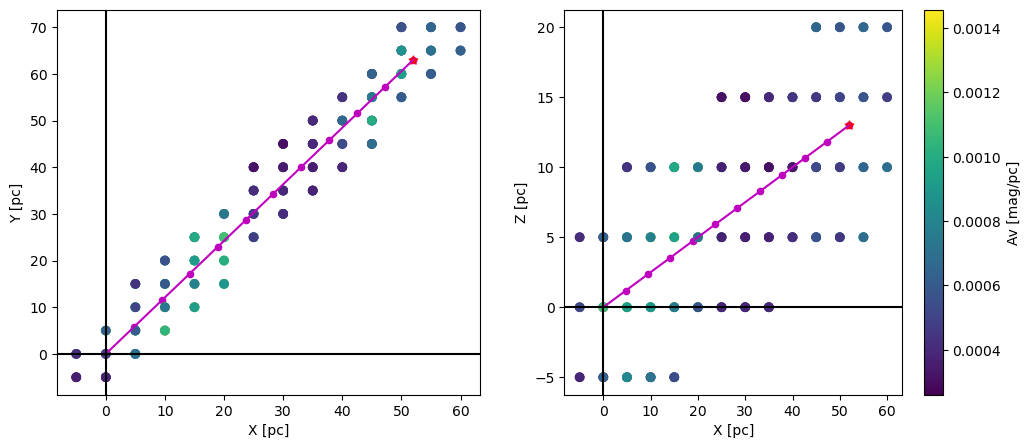

In [26]:
a = compute_extinction(52,63,13,map_av_spec5,
                       Plot=True,Verbose=True)


# 3. Example for a table of stars with RA,DEC,Parallax

In [45]:
# Soubiran et al 2024 table for the GBSv3
# https://vizier.cds.unistra.fr/viz-bin/VizieR?-source=J/A+A/682/A145
table = pd.read_csv('Soubiran24_GBSv3.tsv',sep='\t',comment='#')

In [46]:
# Change coordinates to galactocentric cartesian using astropy
coords_icrs = coord.SkyCoord(ra=table.RA_ICRS * u.degree,
                             dec=table.DE_ICRS * u.degree,
                             distance=(1./table.Plx) * u.kpc,frame='icrs')

vLSR= [0., 240.,0] * (u.km / u.s) # from Reid et al 2014   
v_sun = [11.1, 12.24, 7.25] * (u.km / u.s)  # [vx, vy, vz] from Schonrich (2012)                                                    
coords_gal = coords_icrs.transform_to(coord.Galactocentric(galcen_distance = 8340*u.pc,
                                                      galcen_v_sun=vLSR+v_sun,
                                                      z_sun=27*u.pc))
table = pd.concat([table,pd.DataFrame({'X':coords_gal.x,'Y':coords_gal.y,'Z':coords_gal.z})],axis=1)

# Change coordinates to heliocentric in parsec, to use the extinction map
table['Xpc0'] = (table['X']+8.340)*1000.
table['Ypc0'] = table['Y']*1000.
table['Zpc0'] = (table['Z']-0.027)*1000.

(-20.0, 20.0)

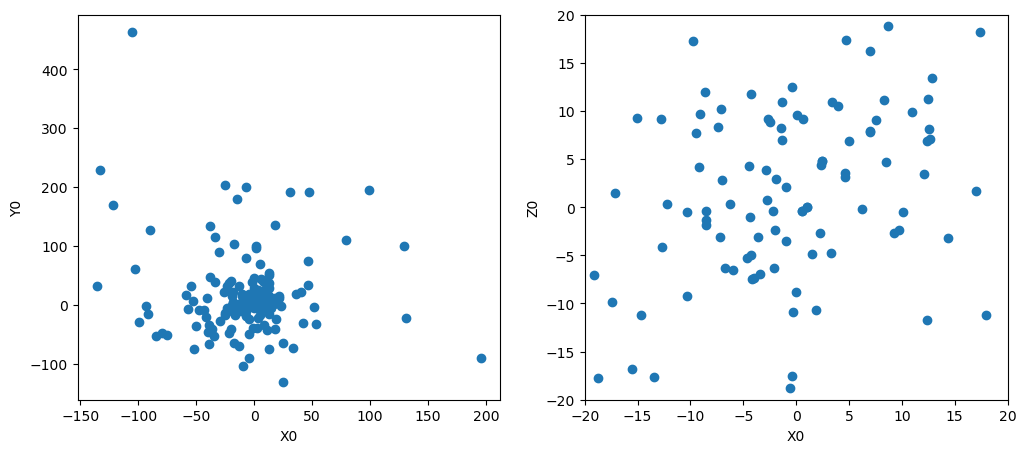

In [48]:
# PLOT

plt.figure(figsize=[12,5])

plt.subplot(1,2,1)
plt.scatter(table.Xpc0,table.Ypc0,marker='o',linestyle='None')
plt.xlabel('X0')
plt.ylabel('Y0')

plt.subplot(1,2,2)
plt.scatter(table.Xpc0,table.Zpc0,marker='o',linestyle='None')
plt.xlabel('X0')
plt.ylabel('Z0')
plt.ylim(-20,20)
plt.xlim(-20,20)


## Compute extinction per star

In [55]:
for i in tqdm(range(len(table))):
    if (table.iloc[i].Xpc0 > 3000.) | (table.iloc[i].Ypc0 > 3000.):
        print('Star out of limits')
    else:
        a = compute_extinction(table.iloc[i].Xpc0,table.iloc[i].Ypc0,table.iloc[i].Zpc0,map_av_spec5,
                       Plot=False,Verbose=False)
        table.loc[i,'Av_Vergely'] = a


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [02:25<00:00,  1.38it/s]


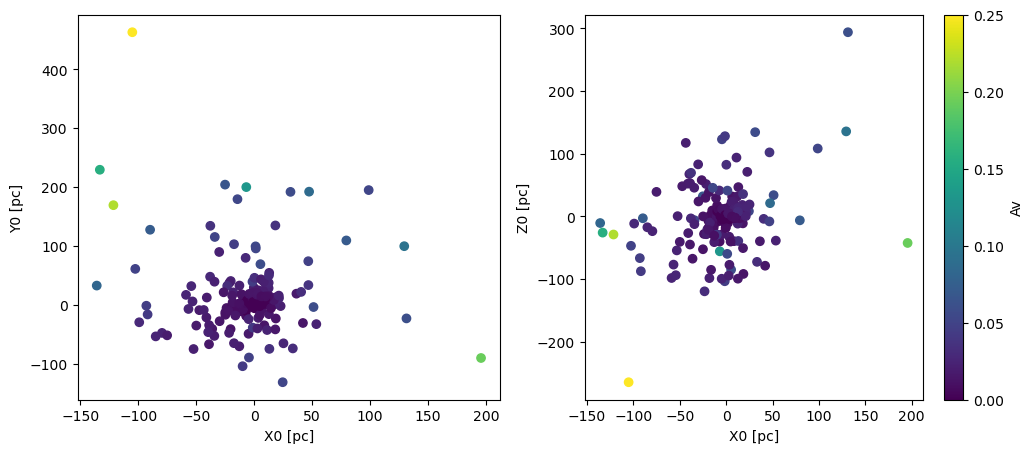

In [56]:
plt.figure(figsize=[12,5])

plt.subplot(1,2,1)
plt.scatter(table.Xpc0,table.Ypc0,c=table['Av_Vergely'],marker='o',linestyle='None',vmax=0.25)
plt.xlabel('X0 [pc]')
plt.ylabel('Y0 [pc]')

plt.subplot(1,2,2)
plt.scatter(table.Xpc0,table.Zpc0,c=table['Av_Vergely'],marker='o',linestyle='None',vmax=0.25)
plt.xlabel('X0 [pc]')
plt.ylabel('Z0 [pc]')
plt.colorbar(label='Av')

# FUNCTION

In [50]:
def compute_extinction(Xstar,Ystar,Zstar,map_av,Verbose=True,Plot=True):
    """
    This function computes the interstellar extinction of the star (Av) based on the X,Y,Z positions
    (cartesian heliocentric) coordinates of the star, and the chosen 3D map from Vergely.
    It uses the LinearNDInterpolator to interpolate the extinction along the line of sight.
    The maps are cut at \pm400pc in Z, so differential extinction is assumed to be 0 outside this region
    
    Xstar,Ystar,Zstar are cartesian heliocentric coordinates in pc
    map_av is the map from Vergely et al (h5 files)
    """
    
    time0 = time.time()
    if Verbose:
        print('\nStarting the definition of the region to interpolate')
    # this allows the code to be quicker only taking the nearby points (10 pc around the line of sight)
    around = 10
    m = map_av.values
    m_restr = m[ (m[:,0]>np.min([0,Xstar])-around) &  (m[:,0]<np.max([0,Xstar])+around) &
                 (m[:,1]>np.min([0,Ystar])-around) &  (m[:,1]<np.max([0,Ystar])+around) &
                 (m[:,2]>np.min([0,Zstar])-around) &  (m[:,2]<np.max([0,Zstar])+around) ]
    map_restricted = pd.DataFrame(m_restr,columns = map_av.columns)

    addz = []
    df_addgrid = 0
    if Zstar > 400:
        addz = np.arange(405,int(Zstar)+around,5)
        addgrid_x,addgrid_y,addgrid_z, = np.meshgrid(map_restricted.X.unique(),map_restricted.Y.unique(),addz)
        df_addgrid = pd.DataFrame({'X':addgrid_x.flatten(),'Y':addgrid_y.flatten(),'Z':addgrid_z.flatten()})
        df_addgrid['Av'] = 0.
        map_restricted = pd.concat([map_restricted,df_addgrid]).reset_index(drop=True)

    elif Zstar < -400:
        addz = np.arange(int(Zstar)-around,-405,5)
        addgrid_x,addgrid_y,addgrid_z, = np.meshgrid(map_restricted.X.unique(),map_restricted.Y.unique(),addz)
        df_addgrid = pd.DataFrame({'X':addgrid_x.flatten(),'Y':addgrid_y.flatten(),'Z':addgrid_z.flatten()})
        df_addgrid['Av'] = 0.
        map_restricted = pd.concat([map_restricted,df_addgrid]).reset_index(drop=True)

    map_restricted['Xdif'] = np.abs(map_restricted['X']-Xstar)
    map_restricted['Ydif'] = np.abs(map_restricted['Y']-Ystar)
    map_restricted['Zdif'] = np.abs(map_restricted['Z']-Zstar)

    map_restricted_ = map_restricted.loc[((map_restricted.Y <  around + map_restricted.X * Ystar/Xstar)
                                        & (map_restricted.Y > -around + map_restricted.X * Ystar/Xstar)
                                        & (map_restricted.Z <  around + map_restricted.X * Zstar/Xstar)
                                        & (map_restricted.Z > -around + map_restricted.X * Zstar/Xstar)) |
                                    (map_restricted.Xdif.isin(np.partition(map_restricted.Xdif.unique(), 1)[0:2]) &
                                     map_restricted.Ydif.isin(np.partition(map_restricted.Ydif.unique(), 1)[0:2]) &
                                     map_restricted.Zdif.isin(np.partition(map_restricted.Zdif.unique(), 1)[0:2]))]
    if Verbose:
        print(f'...done in {time.time()-time0} s')
        

    time1 = time.time()
    if Verbose:
        print('\nStarting interpolation...')
    try:
        interp = LinearNDInterpolator(list(zip(map_restricted_.X, map_restricted_.Y, map_restricted_.Z)), map_restricted_.Av)
    except:
        print('...Error: cannot interpolate...')
        return(0)

    sline = []
    lmax = np.max([np.abs(Xstar),np.abs(Ystar),np.abs(Zstar)])
    nstep = int(abs(lmax)/5.) # I interpolate so there is a maximum of 5pc distance between points
    if Verbose:
        print(f'   I am interpolating {nstep} points')
    for j in [Xstar,Ystar,Zstar]:
        sline.append(np.linspace(0,j,nstep))

    xyz = np.stack([sline[0], sline[1], sline[2]]).T
    av_interp = interp(xyz)
    if Verbose:
        print(f'...done in {time.time()-time1} s')
        
    if Plot:
        ##############################################
        # PLOT in case we want to verify the line of sight and the extinction points
        plt.figure(figsize=[12,5])
        plt.subplot(1,2,1)
        sc = plt.scatter(map_restricted_.X,map_restricted_.Y,
                    c=map_restricted_.Av,marker='o',linestyle='None',
                    vmax=np.max(map_restricted.Av)-(np.max(map_restricted.Av)-np.min(map_restricted.Av))/5)
        plt.plot([0,Xstar],[0,Ystar],c='m')
        plt.scatter(Xstar,Ystar,marker='*',s=40,linestyle='None',c='r')
        plt.scatter(sline[0], sline[1],marker='o',s=20,linestyle='None',c='m',zorder=0)
        plt.xlabel('X [pc]')
        plt.ylabel('Y [pc]')
        plt.axhline(0, color='black')
        plt.axvline(0, color='black')
        
        
        plt.subplot(1,2,2)
        plt.scatter(map_restricted_.X,map_restricted_.Z,
                    c=map_restricted_.Av,marker='o',linestyle='None',
                    vmax=np.max(map_restricted.Av)-(np.max(map_restricted.Av)-np.min(map_restricted.Av))/5)
        plt.colorbar(label='Av [mag/pc]')
        plt.plot([0,Xstar],[0,Zstar],c='m')
        plt.scatter(Xstar,Zstar,marker='*',s=40,linestyle='None',c='r')
        plt.scatter(sline[0], sline[2],marker='o',s=20,linestyle='None',c='m',zorder=0)
        plt.xlabel('X [pc]')
        plt.ylabel('Z [pc]')
        plt.axhline(0, color='black')
        plt.axvline(0, color='black')
        ##############################################

    time2 = time.time()
    if Verbose:
        print('\nStarting integration...')
    av = 0
    for i in range(len(sline[0])-1):
        D = np.sqrt((sline[0][i+1]-sline[0][i])**2 + (sline[1][i+1]-sline[1][i])**2 + (sline[2][i+1]-sline[2][i])**2)
        av = av + av_interp[i]*D
    if Verbose:
        print(f'...done in {time.time()-time2} s')

    
    time3 = time.time()
    if Verbose:
        print('\nFinished star in',np.round(time3-time0,2),'s')

    del m
    del m_restr
    del df_addgrid
    del map_restricted

    return(av)
